### Libraries for EDA:

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from matplotlib import cm
from statsmodels.api import OLS
from pandas.tools.plotting import scatter_matrix
from pandas import scatter_matrix
import scipy as sci

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib inline

### Load, Visualize, and Clean Data

#### Load Data


After reviewing all the available datasets we notice that the features change from 2015 onward and appear to be more informative than on previous years.

Each row corresponds to a snapshot of a loan at the end of the period and has information on the loan itself and the borrowers. Since LendingClub does not provide a unique id for loans or borrowers **it's not posible to join together several periods** to increase the amount of data because we'd be repeating information on loans at differente times, which would distort the outcome of the study.

In [3]:
target_col = "sub_grade"
full_loan_stats = pd.read_csv('LoanStats3d.csv', skiprows=1, skipfooter=2, engine='python')
loan_df = full_loan_stats.copy()

In [5]:
# Remove % sign from 'int_rate' column and cast it to a float
for i in range(len(loan_df['int_rate'].values)):
    loan_df['int_rate'].values[i] = str(loan_df['int_rate'].values[i])[:-1]
    if (loan_df['int_rate'].values[i] == 'na'):
        loan_df['int_rate'].values[i] = '0'
    else:
        loan_df['int_rate'].values[i] = loan_df['int_rate'].values[i]
loan_df['int_rate'] = pd.to_numeric(loan_df['int_rate'])

After loading and cleaning the data we start by making simple visualizations, grouping and descriptive statistics of the dataset by different features to have a first glance at the data. We understand that Lending Club grades loans by their risk which translates in higher risk loans paying higher interests and vice versa. Understanding this and considering the goal of the analysis we decide to work on an initial hypothesis:

- If we can understand how Lending Club grades a loan, we should be able to improve on their grading criteria, "regrade" loans and invest in higher return loans that are less risky than LC graded to be.

To achieve this we will work on three strategies:

- Build a model that accurately grades loans by Lending Club's standards
- Build a model that accurately predicts the likelyhood of default
- Combine Lending Club's data with macro economic indicators that can give us exogenous confounding variables that would potentially increase the predicting accuracy of both models and thus, our competitive advantage  

In [6]:
loan_df.groupby(['loan_status','grade']).agg({ 
    'loan_status' : np.size,
    'loan_amnt' : np.mean,
    'int_rate' : np.mean
})

loan_status     loan_amnt   int_rate
loan_status        grade                                      
Charged Off        A             3612  14094.282946   7.213441
                   B            12426  13868.322469  10.259063
                   C            21014  14355.960312  13.389042
                   D            15623  15779.000512  16.795443
                   E            10792  18200.984526  19.370108
                   F             3865  20046.390686  23.731457
                   G              961  20155.515088  26.891779
Current            A            18127  15301.736360   6.872574
                   B            34785  15612.177663   9.960306
                   C            34442  16564.476511  13.259895
                   D            16589  17525.979565  16.710302
                   E             9376  19247.586924  19.226877
                   F             2204  20154.764065  23.459170
                   G              364  20015.178571  26.868984
Default            B                2  15900.000000  10.760000
                   C                4  14600.000000  13.585000
                   D                1  11200.000000  15.610000
                   E                1  14250.000000  18.550000
Fully Paid         A            51215  14514.148687   6.945670
                   B            69021  13615.635821  10.046774
                   C            62729  13815.288383  13.286663
                   D            29006  15047.968524  16.689827
                   E            13758  18058.189780  19.269988
                   F             3454  20102.569485  23.580599
                   G              780  20803.717949  26.720795
In Grace Period    A              134  16099.626866   7.029254
                   B              542  15741.835793  10.141974
                   C              939  17085.250266  13.363024
                   D              560  18384.196429  16.803232
                   E              359  19329.038997  19.310474
                   F              111  19999.774775  23.522973
                   G               23  24117.391304  27.102609
Late (16-30 days)  A               38  15505.263158   7.100526
                   B              148  14544.932432   9.980338
                   C              269  16383.085502  13.311822
                   D              180  18393.472222  16.685778
                   E              131  20111.832061  19.212137
                   F               35  21058.571429  23.507429
                   G                8  22684.375000  27.493750
Late (31-120 days) A              210  14635.952381   7.143857
                   B              682  14984.237537  10.092053
                   C             1170  15824.145299  13.341427
                   D              695  16982.014388  16.796734
                   E              531  20078.813559  19.303258
                   F              148  19827.871622  23.651284
                   G               31  20937.903226  27.193871

A first view at the distribution of loans by their status shows us that there is no evident logic as to how a loan will come to term just by looking at their grade, amount or interest rate.

Text(0.5,1,'Lending Club Grading Criteria')

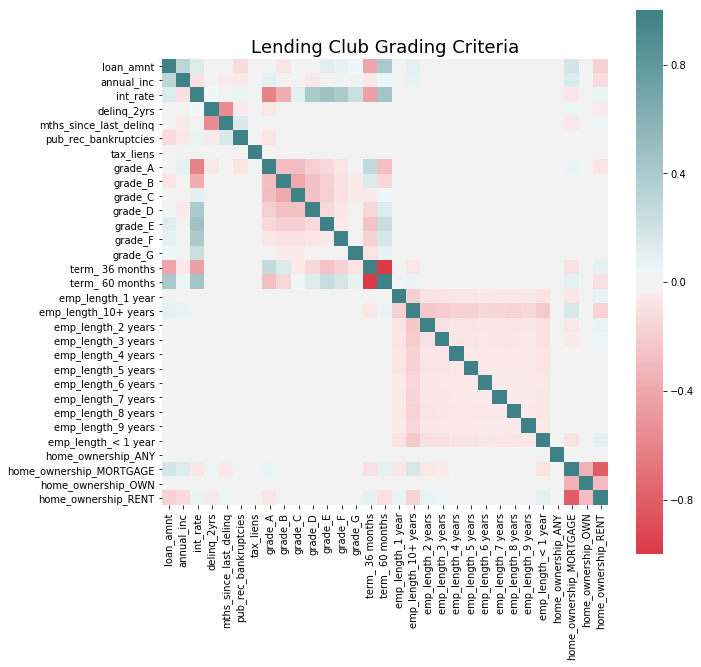

In [11]:
# Try to find the variables that LC considers to assign their grade.
gradingMat = loan_df[['grade','loan_amnt','annual_inc','term','int_rate','delinq_2yrs','mths_since_last_delinq',
                       'emp_length','home_ownership','pub_rec_bankruptcies','tax_liens']]

gradingMatDumm = pd.get_dummies(gradingMat, columns=['grade', 'term','emp_length','home_ownership'])

fig, ax = plt.subplots(figsize=(10, 10))

corr = gradingMatDumm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(10, 200, as_cmap=True, center = 'light'),
            square=True, ax=ax);
ax.set_title('Lending Club Grading Criteria', fontsize=18)

We can see that grade is related to loan amount and term of loan. Grade A seems to consider more variables, such as deliquency in the past 2 years and bankrupcies.

We'll explore now if there are signs of features being potential good predictors of a loan resulting in a default, this being determined by loans with `hardship flag` != N, for which late recovery fees have been collected, loans with percentage of never delinquent != 100, loans with deliquent amounts > 0 or loan status being "charged off".

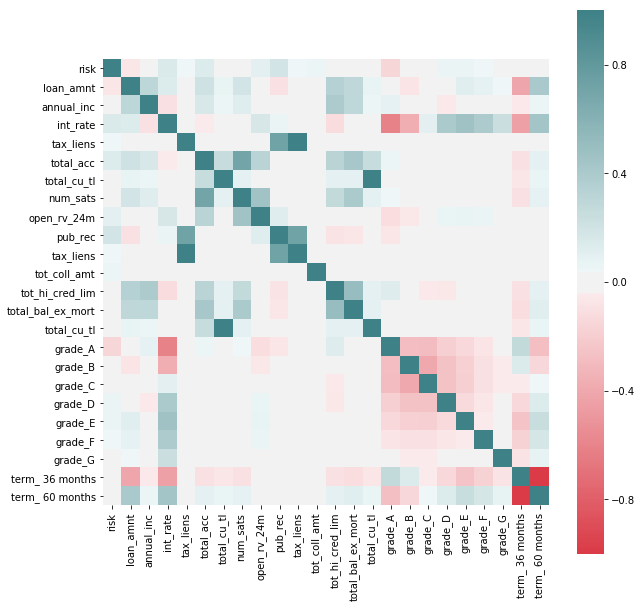

In [12]:
# We create a new feature that will inform of what we'll be considering a default, which we'll use as an outcome that 
# we'll want to avoid.

loan_df['risk'] = int(0)
badLoan = ['Charged Off','Late (31-120 days)',
       'Late (16-30 days)', 'In Grace Period']

loan_df.loc[(loan_df['delinq_amnt'] > 0) | (loan_df['pct_tl_nvr_dlq'] != 100) | 
              (loan_df['total_rec_late_fee'] > 1) | (loan_df['delinq_2yrs'] > 0) | 
              (loan_df['pub_rec_bankruptcies'] > 0) | (loan_df['debt_settlement_flag'] != 'N') |
              loan_df['loan_status'].isin(badLoan),'risk'] = 1

predDefault = loan_df[['risk','grade','loan_amnt','annual_inc','term','int_rate','emp_length','tax_liens','total_acc',
                       'total_cu_tl','hardship_loan_status','num_sats','open_rv_24m','pub_rec','tax_liens',
                       'tot_coll_amt','tot_hi_cred_lim','total_bal_ex_mort','total_cu_tl']]

predDefault = pd.get_dummies(predDefault, columns=['grade', 'term'], drop_first = False)

f, ax = plt.subplots(figsize=(10, 10))

corr = predDefault.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(10, 200, as_cmap=True, center = 'light'),
            square=True, ax=ax)

We see some correlations that may be interesting to explore further between features that indicate potential risk (as by the new feature added to the dataset) and others. We see that the variables by which Lending Club seems to grade loans do indeed have a potential effect on risk (such as term of loan or loan ammount) but we also see others that they don't seem to take in so much consideration as having tax lien or derogatory public records.


It's interesting to point out that better grades, as assigned by Lending Club, don't necessarily correspond with less risk of default, as seen by "charged off" having a negative correlation with Grade G and positive with better levels.

In favor of Lending Club's grading system we see that there seems to be an intrinsic higher risk on higher interest paying loans, at least through this rough preliminary analysis.

##### After all that visualization! Lets Clean the Data!

In [13]:
loans_df = full_loan_stats.copy()
loans_df = loans_df.select_dtypes(include=['float64']).join(loans_df[target_col])

In [14]:
def get_columns_to_drop(df):
    """Returns a list of columns from df that is all NaN"""
    columns_to_drop = []
    for col in loans_df.columns:
        unique_rows = loans_df[col].unique()
        if (unique_rows.size == 1 and not isinstance(unique_rows[0], str) and np.isnan(unique_rows[0])):
            columns_to_drop.append(col)
    return columns_to_drop

In [15]:
# drop columns that contains all NaN values
loans_df_columns_to_drop = get_columns_to_drop(loans_df)
loans_df = loans_df.drop(loans_df_columns_to_drop, axis=1)

In [16]:
loans_df.shape

(421095, 55)

After cleaning the dataset of `loans_df`, we were able to reduce from 145 categories to 55 categories.

In [17]:
loans_df.head()

,funded_amnt_inv,installment,annual_inc,dti,mths_since_last_delinq,mths_since_last_record,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,sub_grade
0,3600.0,123.03,55000.0,5.91,30.0,NaN,822.09,822.09,3560.87,3560.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C4
1,27300.0,977.00,65000.0,25.63,NaN,NaN,0.00,0.00,8727.52,8727.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D3
2,20000.0,672.73,145000.0,12.28,NaN,NaN,4513.01,4513.01,19473.39,19473.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C2
3,10000.0,253.78,55000.0,35.70,NaN,NaN,0.00,0.00,5558.20,5558.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D4
4,25000.0,581.58,79000.0,34.53,NaN,NaN,0.00,0.00,14490.92,14490.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C4


In [18]:
loans_df.describe()

,funded_amnt_inv,installment,annual_inc,dti,mths_since_last_delinq,mths_since_last_record,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,421095.000000,421095.000000,4.210950e+05,421093.000000,217133.000000,74415.000000,421095.000000,421095.000000,421095.000000,421095.000000,...,2225.0,2225.000000,2225.0,2225.000000,1823.000000,2225.000000,2225.000000,8848.000000,8848.000000,8848.000000
mean,15234.156426,441.846219,7.696561e+04,19.148367,34.023391,66.592609,1732.089410,1731.268075,14748.917175,14743.200629,...,3.0,116.966769,3.0,13.935281,344.569715,9255.759685,180.003506,5052.308930,47.616197,12.406420
std,8567.935757,244.846944,7.394996e+04,8.885104,21.990270,25.577899,3935.594539,3933.582273,9341.303762,9337.937536,...,0.0,99.994608,0.0,9.907728,293.692525,6329.988185,184.856483,3642.461692,6.384622,7.760753
min,900.000000,14.010000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.0,0.640000,3.0,0.000000,1.920000,55.730000,0.020000,152.000000,20.000000,0.000000
25%,8500.000000,263.930000,4.600000e+04,12.590000,15.000000,50.000000,0.000000,0.000000,7721.267930,7718.905000,...,3.0,38.700000,3.0,5.000000,115.290000,3931.600000,37.860000,2193.000000,45.000000,6.000000
50%,14000.000000,385.410000,6.500000e+04,18.600000,31.000000,67.000000,0.000000,0.000000,12610.810000,12605.850000,...,3.0,86.580000,3.0,15.000000,252.060000,8005.090000,116.390000,4285.825000,45.000000,12.000000
75%,20000.000000,578.790000,9.169050e+04,25.340000,50.000000,82.000000,666.310000,666.020000,19995.681232,19989.640000,...,3.0,167.310000,3.0,23.000000,495.870000,13356.340000,273.130000,7007.715000,50.000000,18.000000
max,35000.000000,1445.460000,9.500000e+06,999.000000,176.000000,120.000000,28405.440000,28405.440000,57769.155762,57769.160000,...,3.0,638.130000,3.0,30.000000,1914.390000,29401.040000,1247.480000,30000.000000,166.670000,65.000000


### Regression Testing

#### OLS

In [19]:
# Split into test and train
loans_df = loans_df.fillna(0)
train_loan_df, test_loan_df = train_test_split(loans_df, test_size=0.2)
y_loan_train = train_loan_df[target_col]
X_loan_train = train_loan_df.drop(target_col, axis=1)
y_loan_test = test_loan_df[target_col]
X_loan_test = test_loan_df.drop(target_col, axis=1)

In [20]:
# For a character letter pair from A1 to G5 returns it's order in the list
# E.g. A1 = 1, A2 = 2, B1 = 6, G5 = 35
def grade_to_int(grade):
    if len(grade) != 2:
        return 0
    let = ord(grade[0]) - ord('A')
    dig = int(grade[1])
    return let * 5 + dig

def num_to_grade(num):
    let = chr(int(np.floor(num/5)) + ord('A'))
    dig = int(np.round(num)) % 5
    # 1 indexed grades
    if dig == 0:
        let = chr(ord(let) - 1)
        dig = 5
    return let + str(dig)

In [21]:
OLSModel = OLS(y_loan_train.map(grade_to_int), sm.add_constant(X_loan_train)).fit()

In [29]:
r2_score(OLSModel.predict(sm.add_constant(X_loan_test)), y_loan_test.map(grade_to_int))

0.3303237488371052


The OLS model resulted in a $R^2$ value of 0.3303.

Text(0.5,1,'OLS Model $R^2$ Values')

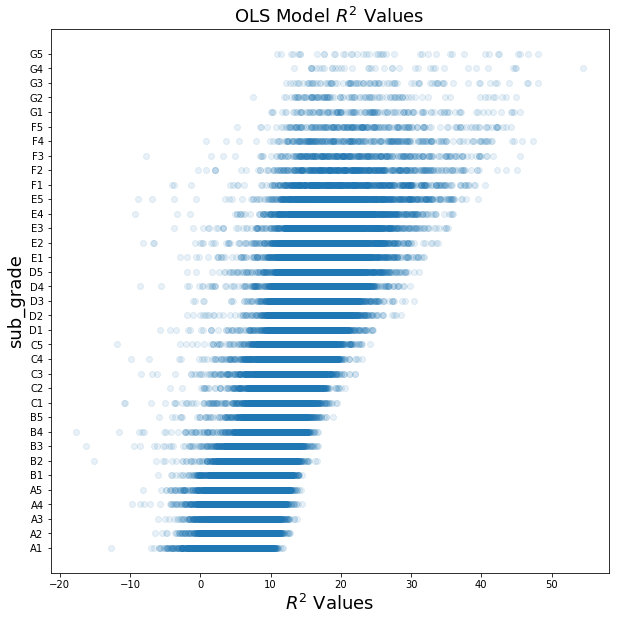

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(OLSModel.predict(sm.add_constant(X_loan_test)), y_loan_test.map(grade_to_int), alpha=0.1)
ax.set_xlabel('$R^2$ Values', fontsize=18)
ax.set_ylabel(target_col, fontsize=18)
y_values = dict((i, num_to_grade(i)) for i in list(range(1, 36)))
ax.set_yticks(list(y_values.keys()))
ax.set_yticklabels(list(y_values.values()))
ax.set_title('OLS Model $R^2$ Values', fontsize=18)

#### OLS with RFE

In [24]:
model = LinearRegression()
selector = RFE(model).fit(X_loan_train, y_loan_train.map(grade_to_int))

In [25]:
r2_score(selector.predict(X_loan_test), y_loan_test.map(grade_to_int))

-0.48433446033411376

That's worse than before. Let's try again and only remove 1/4th of the features to see the $R^2$ improves.

In [26]:
selector = RFE(model, 77).fit(X_loan_train, y_loan_train.map(grade_to_int))

In [27]:
r2_score(selector.predict(X_loan_test), y_loan_test.map(grade_to_int))

0.34345254884079535

Much better! With more trials we can probably find the optimum number of features to remove

Text(0.5,1,'OLS RFE Model $R^2$ Values')

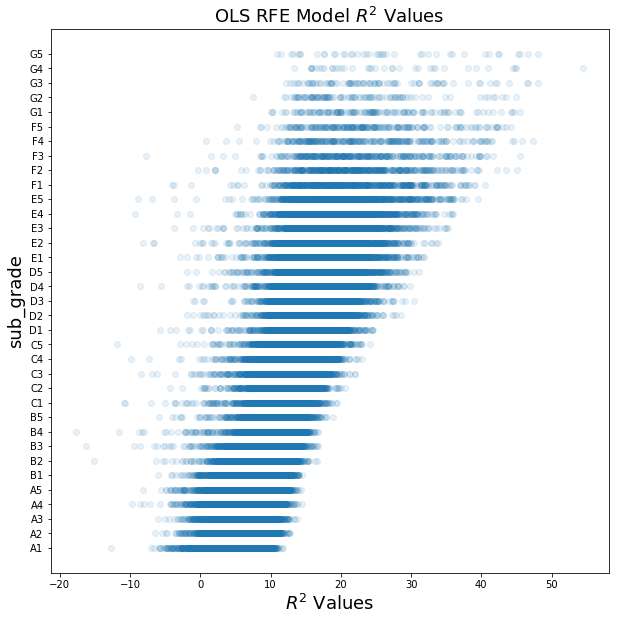

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(OLSModel.predict(sm.add_constant(X_loan_test)), y_loan_test.map(grade_to_int), alpha=0.1)
ax.set_xlabel('$R^2$ Values', fontsize=18)
ax.set_ylabel(target_col, fontsize=18)
y_values = dict((i, num_to_grade(i)) for i in list(range(1, 36)))
ax.set_yticks(list(y_values.keys()))
ax.set_yticklabels(list(y_values.values()))
ax.set_title('OLS RFE Model $R^2$ Values', fontsize=18)

#### Logistic Regression

Let's try our Logistic Regressions on our dataset. Future plans are to include cross validations with Ridge/Lasso Regularization to prevent overfitting. 

_Due to the limited computational resources, the following executations can take a while to process._

In [ ]:
model = LogisticRegression()
model.fit(X_loan_train, y_loan_train.map(grade_to_int))

In [ ]:
model.score

In [ ]:
r2_score(model.predict(X_loan_test), y_loan_test.map(grade_to_int))

In [ ]:
plt.scatter(model.predict(X_loan_test), y_loan_test.map(grade_to_int), alpha=0.1)
plt.show()

#### Logistic Regression with RFE

In [ ]:
model = LogisticRegression()
selector = RFE(model).fit(X_loan_train, y_loan_train.map(grade_to_int))

In [ ]:
r2_score(selector.predict(X_loan_test), y_loan_test.map(grade_to_int))

In [ ]:
selector = RFE(model, 77).fit(X_loan_train), y_loan_train.map(grade_to_int), step=5)
r2_score(selector.predict(X_loan_test), y_loan_test.map(grade_to_int))

In [ ]:
plt.scatter(selector.predict(X_loan_test), y_loan_test.map(grade_to_int), alpha=0.1)

### Feature Engineering

Let's try to use feature engineering to improve the model. We will be importing the average adjusted gross income based on the applicant's zip code and determining if the demographic area is significant. This dataset was available publicly on www.irs.gov/statistics.

Since the dataset from `LendingTree` only contains the first 3 digits of the applicant's zip code, we will use the average of the first 3 digits of the zip code for the demographic adjusted gross income. Future plans are to include cross validations with Ridge/Lasso Regularization to prevent overfitting. 

Time for some data loading and cleaning to see the results!

#### Load and Clean Data

In [31]:
# Adding `zip_code` from `full_loans_df`, since it was removed earlier
loans_df['zip_code'] = full_loan_stats['zip_code'].str[:3].astype(np.int64)

In [32]:
# IRS specifies NI as Number of Returns and A00100 as Total Adjusted Gross Income
full_agi = pd.read_csv('15zpallnoagi.csv')
agi_df = full_agi[['ZIPCODE', 'N1', 'A00100']].copy()
agi_df['adj_gross_income'] = round((agi_df['A00100']/agi_df['N1'])*1000, 2)
agi_df['zip_code'] = agi_df['ZIPCODE'].astype(str).str[:3].astype(np.int64)

In [33]:
# Group the adjusted gross income by the first three digits of the zip code
agi_df = agi_df.groupby(['zip_code'], as_index=False)['adj_gross_income'].mean()
agi_df = agi_df.round({'adj_gross_income': 2})

In [34]:
# Use a left join to join `agi_df` onto `loans_df`
loans_df = pd.merge(loans_df, agi_df, how='left', on=['zip_code'])
loans_df = loans_df.fillna(0)

#### OLS

In [35]:
train_loan_df, test_loan_df = train_test_split(loans_df, test_size=0.2)
y_loan_train = train_loan_df[target_col]
X_loan_train = train_loan_df.drop(target_col, axis=1)
y_loan_test = test_loan_df[target_col]
X_loan_test = test_loan_df.drop(target_col, axis=1)

In [36]:
OLSModel = OLS(y_loan_train.map(grade_to_int), sm.add_constant(X_loan_train)).fit()

In [38]:
r2_score(OLSModel.predict(sm.add_constant(X_loan_test)), y_loan_test.map(grade_to_int))

0.34136288693706146


The OLS model with adjusted gross income resulted in a $R^2$ value of 0.3414. <br />
The OLS model with no income resulted in a $R^2$ value of 0.3303. <br />
The adjusted gross income did improve our model, but was not signicantly.

Text(0.5,1,'OLS Adjusted Gross Income $R^2$ Values')

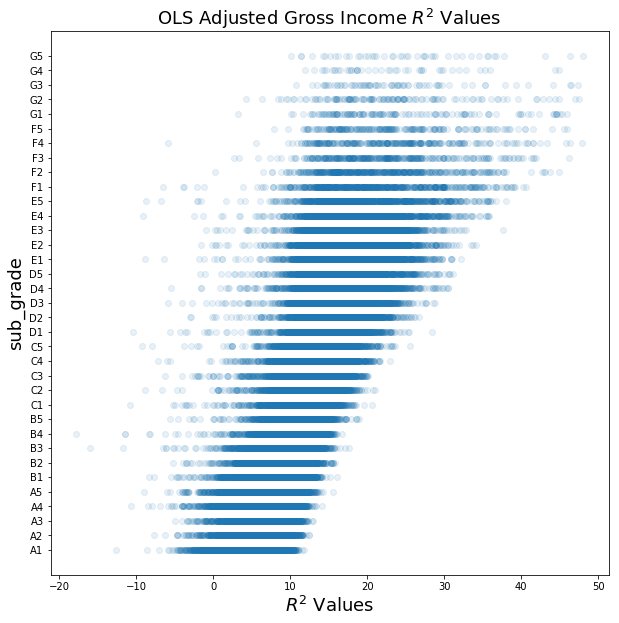

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(OLSModel.predict(sm.add_constant(X_loan_test)), y_loan_test.map(grade_to_int), alpha=0.1)
ax.set_xlabel('$R^2$ Values', fontsize=18)
ax.set_ylabel(target_col, fontsize=18)
y_values = dict((i, num_to_grade(i)) for i in list(range(1, 36)))
ax.set_yticks(list(y_values.keys()))
ax.set_yticklabels(list(y_values.values()))
ax.set_title('OLS Adjusted Gross Income $R^2$ Values', fontsize=18)

#### OLS with RFE

In [40]:
model = LinearRegression()
selector = RFE(model, 55).fit(X_loan_train, y_loan_train.map(grade_to_int))
r2_score(selector.predict(X_loan_test), y_loan_test.map(grade_to_int))

0.32201252789623513

When using RFE, it lowers our $R^2$ value, but not significantly.

Text(0.5,1,'OLS RFE Adjusted Gross Income $R^2$ Values')

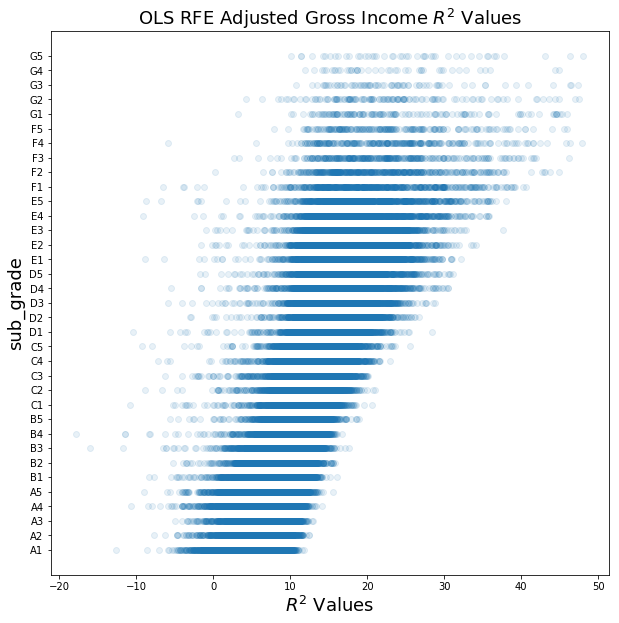

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(OLSModel.predict(sm.add_constant(X_loan_test)), y_loan_test.map(grade_to_int), alpha=0.1)
ax.set_xlabel('$R^2$ Values', fontsize=18)
ax.set_ylabel(target_col, fontsize=18)
y_values = dict((i, num_to_grade(i)) for i in list(range(1, 36)))
ax.set_yticks(list(y_values.keys()))
ax.set_yticklabels(list(y_values.values()))
ax.set_title('OLS RFE Adjusted Gross Income $R^2$ Values', fontsize=18)

#### Conclusion

At this stage of the analysis we still can't confirm our discard our initial hypothesis (that we can build a model that assesses risk better than that of LC) but we feel confident that we can. 

LC strongly bases their grading system on FICO, loan amount and term of the loan, which in turn does not make it too different from the traditional banking system. We would like to build a model based on more complex predictors that can give an oportunity to a wider group of population by identifiying "good borrowers" that may not have a perfect FICO score but will not default.